# Tibia Auction Market Analysis - Price Prediction Model

Building on the data exploration phase, this notebook focuses on creating a predictive model to estimate character auction prices. Using machine learning techniques, I aim to build a reliable price prediction system that can help players and traders assess character value.

## Analysis Goals:
1. **Correlation Analysis** - identifying key price drivers
2. **Feature Engineering** - creating vocation-specific variables  
3. **Model Development** - building and training ML algorithms
4. **Model Evaluation** - testing accuracy and feature importance

## Research Questions:
- Which character attributes have the strongest correlation with price?
- How accurately can we predict auction prices?
- What's the relative importance of different features?
- How do vocation-specific skills impact pricing?

## Expected Outcomes:
- Quantified relationships between character stats and prices
- Trained model capable of price prediction
- Feature importance ranking for pricing decisions


**Libraries imports**

In [1]:
# data manipulation and analysis
import pandas as pd
import numpy as np

# DB connection
import psycopg2
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# statistical analysis
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("Libraries imported successfully.")

Libraries imported successfully.


**Connection with database**

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Database connection config from environment variables
DB_CONFIG = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'port': os.getenv('DB_PORT', '5432'),
    'database': os.getenv('DB_NAME', 'auction_data'),
    'user': os.getenv('DB_USER', 'scraper'),
    'password': os.getenv('DB_PASSWORD')
}

# Create connection string
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"

# Create engine
engine = create_engine(connection_string)

print("Database connection configured.")


Database connection configured.


In [4]:
# Indexes were created in data_exploration.ipynb

schema_query = """
SELECT 
    a.id AS auction_id,
    a.current_bid,
    a.auction_end,
    c.id AS character_id, 
    c.vocation_id, 
    c.level, 
    c.sex,
    c.achievement_points,
    c.boss_points,
    c.charm_total,
    c.charm_expansion,
    c.prey_slot,
    c.hunting_slot,
    c.transfer,
    c.gems_greater,
    c.outfits_count,
    c.mounts_count,
    c.store_mounts_count,
    c.store_outfits_count,
    c.hirelings_count,
    s.magic, s.axe, s.sword, s.club, s.distance, s.shielding, s.fist,
    w.pvp_type,
    w.battleye,
    w.location
FROM auctions a 
JOIN characters c ON a.character_id = c.id
LEFT JOIN skills s ON c.skills_id = s.id
LEFT JOIN worlds w ON c.world_id = w.id
WHERE a.has_been_bidded = true
    AND a.is_historical = true
"""
auctions_df = pd.read_sql(schema_query, engine)

auctions_df['auction_end_dt'] = pd.to_datetime(auctions_df['auction_end'], unit='s')
auctions_df['auction_month'] = auctions_df['auction_end_dt'].dt.month
auctions_df['auction_day_of_week'] = auctions_df['auction_end_dt'].dt.dayofweek

display(auctions_df.head())
print(auctions_df.info())

,auction_id,current_bid,auction_end,character_id,vocation_id,level,sex,achievement_points,boss_points,charm_total,...,club,distance,shielding,fist,pvp_type,battleye,location,auction_end_dt,auction_month,auction_day_of_week
0,1935103,102,1755334800,1935103,4,142,False,76,0,0,...,18.13,18.48,37.69,13.26,Open,False,NA,2025-08-16 09:00:00,8,5
1,1914530,1801,1752915600,1914530,4,393,False,160,2185,2624,...,15.78,18.97,35.27,12.55,Open,False,EU,2025-07-19 09:00:00,7,5
2,1985156,401,1761296400,1985156,1,188,True,37,0,50,...,32.33,12.93,100.20,27.86,Open,False,NA,2025-10-24 09:00:00,10,4
3,1973849,1751,1759914000,1973849,4,333,False,97,310,960,...,12.06,14.25,31.31,11.99,Optional,True,BR,2025-10-08 09:00:00,10,2
4,1946198,821,1759136400,1946198,4,167,False,211,0,290,...,17.26,14.05,37.67,17.82,Optional,False,NA,2025-09-29 09:00:00,9,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815152 entries, 0 to 815151
Data columns (total 33 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   auction_id           815152 non-null  int64         
 1   current_bid          815152 non-null  int64         
 2   auction_end          815152 non-null  int64         
 3   character_id         815152 non-null  int64         
 4   vocation_id          815152 non-null  int64         
 5   level                815152 non-null  int64         
 6   sex                  815152 non-null  bool          
 7   achievement_points   815152 non-null  int64         
 8   boss_points          815152 non-null  int64         
 9   charm_total          815152 non-null  int64         
 10  charm_expansion      815152 non-null  bool          
 11  prey_slot            815152 non-null  bool          
 12  hunting_slot         815152 non-null  bool          
 13  transfer      

In [5]:
print("Unique vocation_id values in data:")
print(auctions_df['vocation_id'].value_counts().sort_index())


Unique vocation_id values in data:
vocation_id
0      1363
1    249867
2    220784
3    149761
4    186499
5      6878
Name: count, dtype: int64


## Feature engineering - Vocation-Specific Skills

In [6]:
# 1. Knight main melee skill (max of sword, axe, club)
auctions_df['knight_melee'] = auctions_df[['sword', 'axe', 'club']].max(axis=1)

# 2. Identify dominant weapon type for Knights
auctions_df['weapon_type'] = auctions_df[['sword', 'axe', 'club']].idxmax(axis=1)

# 3. Create vocation-specific main skills
auctions_df['main_skill'] = 0.0

# Rookie/None (vocation_id = 0): no specific main skill - use level as proxy
rookie_mask = auctions_df['vocation_id'] == 0
auctions_df.loc[rookie_mask, 'main_skill'] = auctions_df.loc[rookie_mask, 'level'] / 10  # Scale down level

# Knight (vocation_id = 1): melee combat skills
knight_mask = auctions_df['vocation_id'] == 1
auctions_df.loc[knight_mask, 'main_skill'] = auctions_df.loc[knight_mask, 'knight_melee']

# Paladin (vocation_id = 2): distance fighting
paladin_mask = auctions_df['vocation_id'] == 2
auctions_df.loc[paladin_mask, 'main_skill'] = auctions_df.loc[paladin_mask, 'distance']

# Druid (vocation_id = 3): magic level
druid_mask = auctions_df['vocation_id'] == 3
auctions_df.loc[druid_mask, 'main_skill'] = auctions_df.loc[druid_mask, 'magic']

# Sorcerer (vocation_id = 4): magic level
sorcerer_mask = auctions_df['vocation_id'] == 4
auctions_df.loc[sorcerer_mask, 'main_skill'] = auctions_df.loc[sorcerer_mask, 'magic']

# Monk (vocation_id = 5): fist fighting
monk_mask = auctions_df['vocation_id'] == 5
auctions_df.loc[monk_mask, 'main_skill'] = auctions_df.loc[monk_mask, 'fist']

# Secondary skill (shielding for Knights and Paladins)
auctions_df['secondary_skill'] = 0.0
auctions_df.loc[auctions_df['vocation_id'].isin([1, 2]), 'secondary_skill'] = auctions_df['shielding']

# 4. Percentile ranking for main_skill within each vocation
auctions_df['main_skill_percentile'] = auctions_df.groupby('vocation_id')['main_skill'].rank(pct=True)

# Update vocation mapping
vocation_mapping = {
    0: 'Rookie/None',
    1: 'Knight',
    2: 'Paladin', 
    3: 'Druid',
    4: 'Sorcerer',
    5: 'Monk'
}

print("\n-- Main Skill Analysis by Vocation --")
for vocation_id in sorted(auctions_df['vocation_id'].unique()):
    if vocation_id in vocation_mapping:
        vocation_name = vocation_mapping[vocation_id]
        v_data = auctions_df[auctions_df['vocation_id'] == vocation_id]
        

        stats = v_data['main_skill'].describe()
        
        # Determine skill name based on vocation
        if vocation_id == 0:
            skill_name = "Level (scaled /10)"
        elif vocation_id == 1:
            skill_name = "Melee Combat (max of sword/axe/club)"
        elif vocation_id == 2:
            skill_name = "Distance Fighting"
        elif vocation_id in [3, 4]:
            skill_name = "Magic Level"
        elif vocation_id == 5:
            skill_name = "Fist Fighting"
        
        print(f"\n {vocation_name.upper()}:")
        print(f"Count:   {int(stats['count'])} characters")
        print(f"Average: {stats['mean']:.2f} ({skill_name})")
        print(f"Median:  {stats['50%']:.2f} ({skill_name})")
        print(f"Max:     {stats['max']:.2f} ({skill_name})")
        
        if vocation_id == 1:  # Knight
            weapon_dist = v_data['weapon_type'].value_counts(normalize=True) * 100
            print("  - Weapon Meta (Most popular weapon type):")
            for w_type, percent in weapon_dist.items():
                print(f"    {w_type.capitalize()}: {percent:.1f}%")
            print(f"  - Avg Shielding: {v_data['shielding'].mean():.2f} (Secondary defensive skill)")
        
        if vocation_id == 2:  # Paladin
            print(f"  - Avg Shielding: {v_data['shielding'].mean():.2f} (Secondary defensive skill)")



-- Main Skill Analysis by Vocation --

 ROOKIE/NONE:
Count:   1363 characters
Average: 3.54 (Level (scaled /10))
Median:  2.70 (Level (scaled /10))
Max:     20.00 (Level (scaled /10))

 KNIGHT:
Count:   249867 characters
Average: 108.12 (Melee Combat (max of sword/axe/club))
Median:  109.88 (Melee Combat (max of sword/axe/club))
Max:     144.18 (Melee Combat (max of sword/axe/club))
  - Weapon Meta (Most popular weapon type):
    Sword: 48.0%
    Axe: 29.3%
    Club: 22.7%
  - Avg Shielding: 101.06 (Secondary defensive skill)

 PALADIN:
Count:   220784 characters
Average: 111.85 (Distance Fighting)
Median:  113.50 (Distance Fighting)
Max:     145.34 (Distance Fighting)
  - Avg Shielding: 99.71 (Secondary defensive skill)

 DRUID:
Count:   149761 characters
Average: 85.05 (Magic Level)
Median:  84.59 (Magic Level)
Max:     147.48 (Magic Level)

 SORCERER:
Count:   186499 characters
Average: 88.27 (Magic Level)
Median:  88.67 (Magic Level)
Max:     142.59 (Magic Level)

 MONK:
Count:   

**Conclusions**
**Skills gap**: The data clearly shows that "numbers aren't equal." Knights and Paladins usually have skills around 110–113, while Mages (Druid and Sorcerer) sit around 85–88. This is normal because Magic Level is much harder to train. Your use of percentiles is a smart move—it tells the model that an 88 ML Druid is just as "elite" as a 110 Axe Knight.

**The "Sword" Meta**: Almost half of all Knights (48%) use Swords. This means Sword characters are the most common on the market. Clubs are the rarest (22.7%). This distribution helps the model understand if certain weapon types carry a "rarity premium" or if they are cheaper because they are less popular.

**Shielding matters**: Paladins have a high average shielding (99.71). By adding secondary_skill, you’re helping the model distinguish between a "rushed" character (high distance, low shield) and a "well-rounded" one, which usually sells for more.

**Knight Defense Parity**: Knights show equally impressive shielding skills (101.06), actually slightly higher than Paladins. This confirms that both tank vocations prioritize defense equally. The model now captures this dual-skill requirement—a Knight needs both high melee combat AND high shielding to be truly valuable. Characters with unbalanced skills (high sword, low shield) will likely sell for less than well-rounded tanks.

**Top-tier Outliers**: There are some characters with skills up to 144-147. These are the "unicorns" of the market. They don't follow normal price rules and will likely be the most expensive auctions in this dataset.

**Monks**: There's only about 6,800 Monks. Since they aren't a standard profession in the main game, these are likely special collectors' items or from a specific game mode. Keeping them separate or labeled is good because their prices won't follow the same logic as a level 500 Sorcerer.

# Analysis of correlation with price

=== CORRELATION ANALYSIS ===

Correlations with auction price (current_bid):
• level: 0.659
• charm_total: 0.631
• achievement_points: 0.506
• outfits_count: 0.500
• mounts_count: 0.495
• boss_points: 0.399
• main_skill_percentile: 0.397
• store_outfits_count: 0.380
• main_skill: 0.316
• store_mounts_count: 0.286
• fist: 0.205
• magic: 0.112
• shielding: 0.073
• sword: 0.062
• club: 0.058
• axe: 0.056
• distance: 0.046



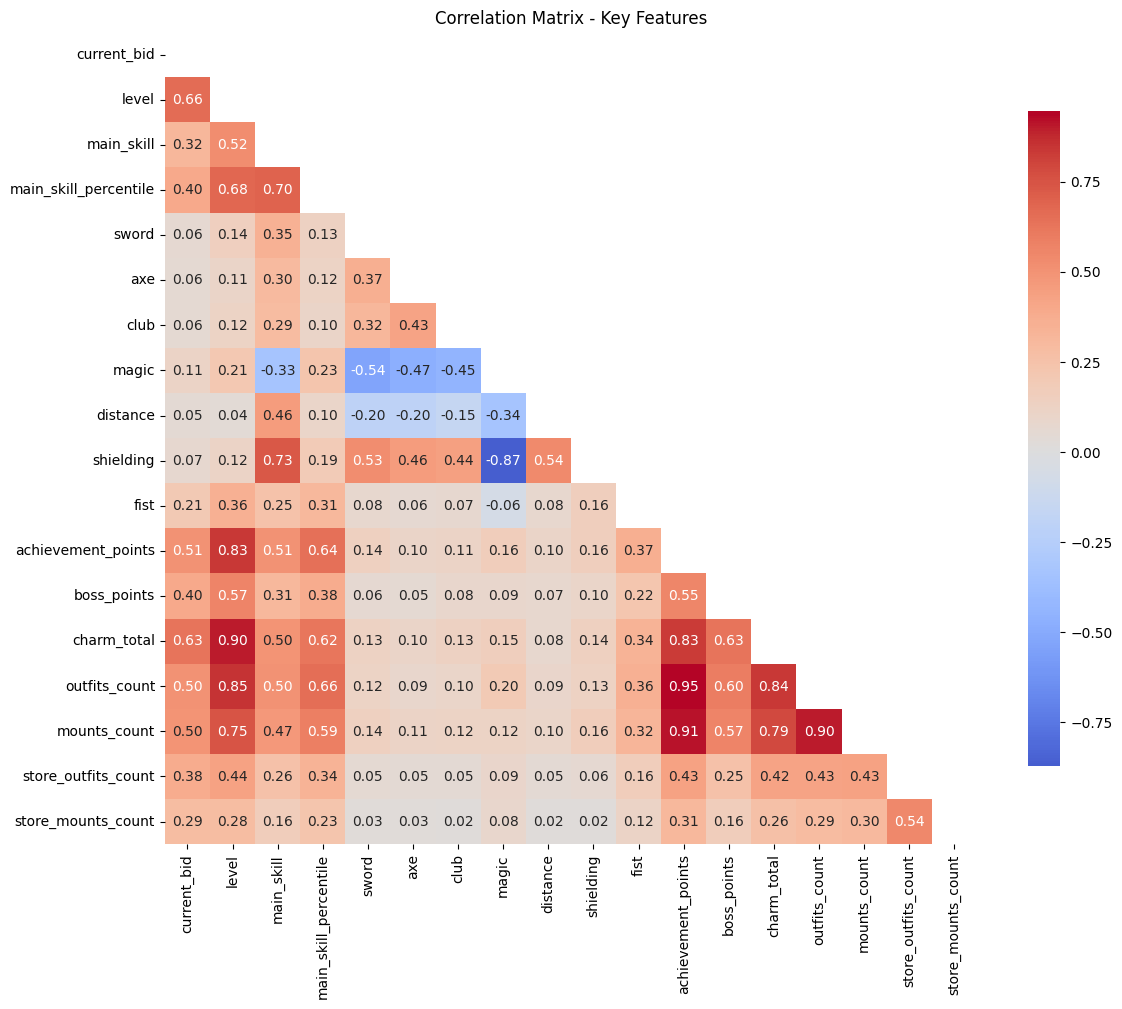

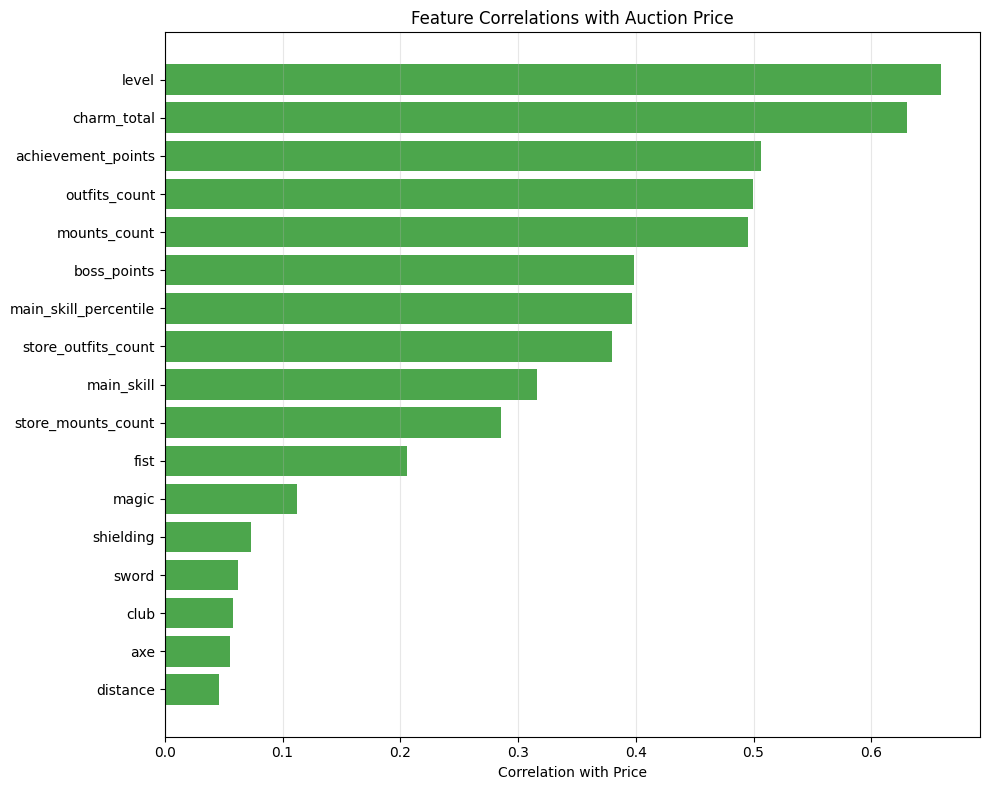

In [7]:
print("=== CORRELATION ANALYSIS ===\n")

# Select numeric features for correlation analysis
numeric_features = ['current_bid', 'level', 'main_skill', 'main_skill_percentile', 
                   'sword', 'axe', 'club', 'magic', 'distance', 'shielding', 'fist',
                   'achievement_points', 'boss_points', 'charm_total',
                   'outfits_count', 'mounts_count', 'store_outfits_count', 'store_mounts_count']

# Calculate correlation matrix
correlation_matrix = auctions_df[numeric_features].corr()

# Display correlations with price (current_bid)
price_correlations = correlation_matrix['current_bid'].sort_values(ascending=False)
print("Correlations with auction price (current_bid):")
for feature, corr in price_correlations.items():
    if feature != 'current_bid':
        print(f"• {feature}: {corr:.3f}")
print("\n" + "="*50)

# Correlation heatmap visualization
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Key Features')
plt.tight_layout()
plt.show()

# Focus on price correlations visualization
plt.figure(figsize=(10, 8))
price_corr_df = price_correlations.drop('current_bid').to_frame('correlation')
price_corr_df['abs_correlation'] = price_corr_df['correlation'].abs()
price_corr_df = price_corr_df.sort_values('correlation')


colors = ['red' if x < 0 else 'green' for x in price_corr_df['correlation']]
plt.barh(range(len(price_corr_df)), price_corr_df['correlation'], color=colors, alpha=0.7)
plt.yticks(range(len(price_corr_df)), price_corr_df.index)
plt.xlabel('Correlation with Price')
plt.title('Feature Correlations with Auction Price')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


**Dominance of progression features**: level (0.659) and charm_total (0.631) are the strongest predictors of price. This makes sense as they represent the total time and effort invested in a character. Charms, in particular, are a major "grind" factor that buyers are willing to pay a premium for.

One of the most significant results is the comparison between skills:

**main_skill_percentile** (0.397)

**main_skill** (0.315)

The percentile-based skill has a significantly higher correlation with price than the raw skill value. This proves that the market values a character based on how strong it is relative to its vocation rather than the absolute number. It justifies the logic that 90 Magic Level is worth more than 100 Sword Fighting.

**Collection and prestige value**: achievement_points, outfits_count, and mounts_count all show strong correlations (approx. 0.50). This indicates a healthy "collector's market" where purely cosmetic or prestige attributes significantly drive up the final bid.

**Raw Skill Noise**: Individual skills like sword, axe, club, and distance show very low correlations (0.04 - 0.06). This is expected because these values are "noisy"—a high sword value is irrelevant to a Druid buyer. This confirms why we needed to consolidate them into a single main_skill feature.

Missing values check:
level                    0
main_skill               0
main_skill_percentile    0
secondary_skill          0
achievement_points       0
boss_points              0
charm_total              0
outfits_count            0
mounts_count             0
store_outfits_count      0
store_mounts_count       0
vocation_id              0
weapon_type              0
prey_slot                0
hunting_slot             0
charm_expansion          0
transfer                 0
pvp_type                 0
location                 0
battleye                 0
dtype: int64

Total missing values: 0

Final feature count: 29
Final feature list:
['level', 'main_skill', 'main_skill_percentile', 'secondary_skill', 'achievement_points', 'boss_points', 'charm_total', 'outfits_count', 'mounts_count', 'store_outfits_count', 'store_mounts_count', 'vocation_id', 'prey_slot', 'hunting_slot', 'charm_expansion', 'transfer', 'battleye', 'weapon_type_axe', 'weapon_type_club', 'weapon_type_sword', 'pvp_type_

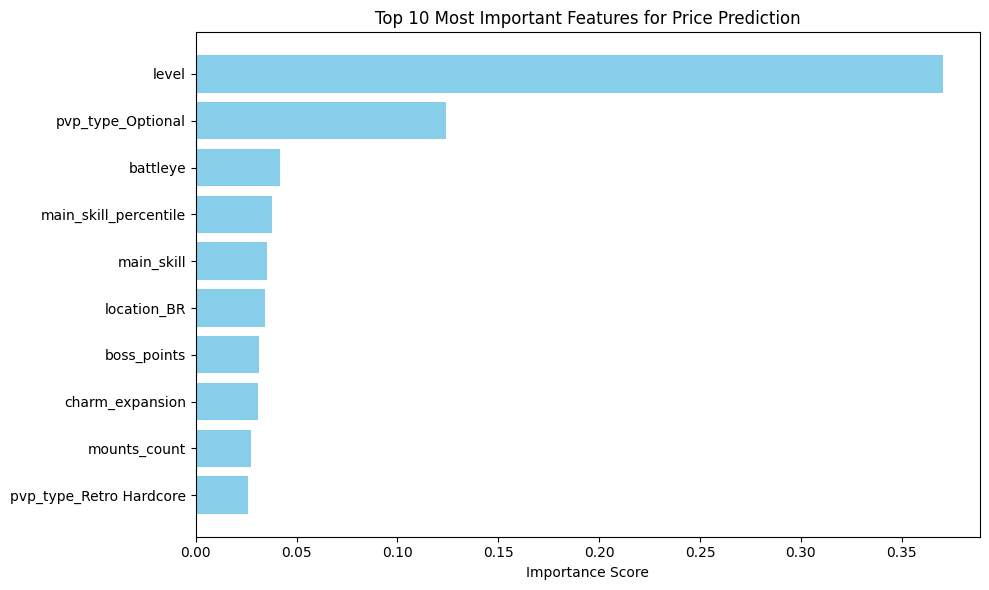

In [16]:
# 1. Select features for the model
#I use our newly created features and the ones with high correlation
features = [
    'level', 'main_skill', 'main_skill_percentile', 'secondary_skill',
    'achievement_points', 'boss_points', 'charm_total',
    'outfits_count', 'mounts_count', 'store_outfits_count', 'store_mounts_count',
    'vocation_id', 'weapon_type',
    #premium features
    'prey_slot', 'hunting_slot', 'charm_expansion', 'transfer', 
    #word features
    'pvp_type', 'location', 'battleye'
]

X = auctions_df[features].copy()
y = auctions_df['current_bid']

#check for missing values before training
print("Missing values check:")
print(X.isnull().sum())
print(f"\nTotal missing values: {X.isnull().sum().sum()}")

# 2. Encode categorical variables
# Convert into dummy variables (0/1)
categorical_columns = ['weapon_type', 'pvp_type', 'location']
X = pd.get_dummies(X, columns=categorical_columns, prefix=categorical_columns)

#convert boolean columns into int

boolean_columns = ['prey_slot', 'hunting_slot','charm_expansion', 'transfer', 'battleye']
for col in boolean_columns:
    if col in X.columns:
        X[col]= X[col].astype(int)

print(f"\nFinal feature count: {X.shape[1]}")
print("Final feature list:")
print(X.columns.tolist())

# 3. Split data into Training and Testing sets
# 80% for learning, 20% for testing the accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Initialize and Train the Model (XGBoost)
print("Training the XGBoost model....")
model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1 # Use all available CPU cores
)

model.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = model.predict(X_test)
mae_first = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


print("\n=== MODEL PERFORMANCE ===")
print(f"Mean Absolute Error: {mae_first:.2f} TC") # avg error in TC
print(f"R2 Score: {r2:.4f}") # how well the model explains the price variance (target > 0.8)
print(f"RMSE: {rmse:.2f} TC")

# 6. Feature Importance, what the model actually learned
import matplotlib.pyplot as plt

importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'][:10], importance['importance'][:10], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 10 Most Important Features for Price Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
#plt.savefig('feature_importance.png')
plt.close()

The result R² = 0.8615 is very robust. This means that the selected traits (Level, Skills, Premium Features, World Characteristics) explain nearly 80% of the differences in character prices in the Bazaar. The model "understands" the general principles governing the market well, including the impact of premium slots like Prey Slot and geographical market differences.

The average error (MAE) is 844 TC. Although it seems significant, it is important to remember that the price range is huge - from 57 TC to over 1,100,000 TC. For mid- and high-level characters, the model already provides a realistic benchmark for pricing.

A result of RMSE of 3,204 TC (much higher than MAE) suggests that the data contains so-called outliers (auctions with very unusual prices, e.g., ultra-rare characters with premium collections or extremely high skills), which severely "penalize" the model for large mistakes. The model performs excellently for typical market transactions but struggles with the "unicorn" auctions that don't follow standard pricing logic.

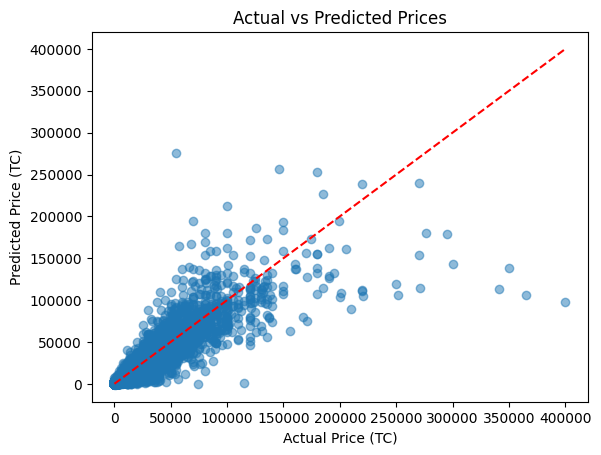

In [17]:
# Create a comparison table for the test set
results = pd.DataFrame({
    'Actual_Price': y_test,
    'Predicted_Price': y_pred
})
results['Difference'] = results['Predicted_Price'] - results['Actual_Price']

# Plotting the results
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Perfect prediction line
plt.xlabel('Actual Price (TC)')
plt.ylabel('Predicted Price (TC)')
plt.title('Actual vs Predicted Prices')
plt.show()

The graph shows a clear trend along the red dashed line, as evidenced by $R^2 = 0.8615$. The model correctly identifies the overall value of the character. 

**Wide tail problem**: A "funnel effect" is noticeable – the higher the character price, the further the points move away from the red line. This means that the model's error increases with the character's value. The baseline model treats a 1000 TC error the same for a 500 TC character (where it is a critical error) as it does for a 50,000 TC character (where it is a negligible error). 

**Underestimation of record auctions**: Many of the points on the right side of the graph fall below the red line. This suggests that the model tends to underestimate the prices of the most expensive, unique characters.

### Model Improvement: Log Transformation
After analyzing the baseline model, I noticed that character prices grow exponentially rather than linearly. 
To improve accuracy for both cheap and expensive auctions, I applied a **Log Transformation** to the target variable (`current_bid`). 
This helps the model focus on percentage errors rather than absolute differences.

Training the optimized XGBoost model on log prices...

=== OPTIMIZED MODEL PERFORMANCE (LOG SCALE) ===
Old MAE: 844.34 TC
New MAE: 809.34 TC
New R2 Score: 0.8582


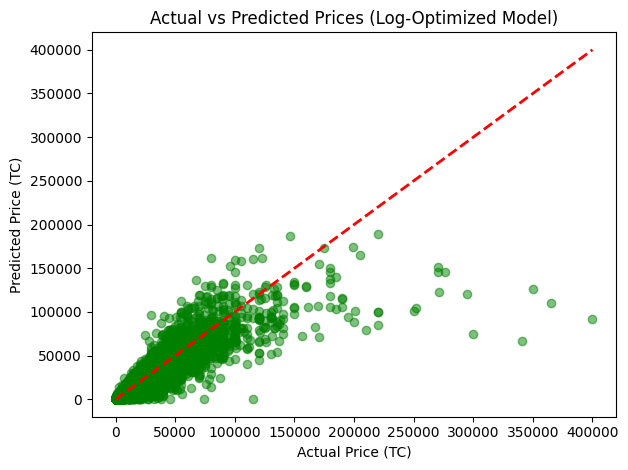

In [18]:
# 1. Transform the target variable (Log transformation)
# We use log1p (log(1+x)) to safely handle any zero values and improve stability
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# 2. Initialize and train the improved model on LOG prices
print("Training the optimized XGBoost model on log prices...")
log_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

log_model.fit(X_train, y_train_log)

# 3. Predict and transform back to the original scale
# We use expm1 (exp(x)-1) to reverse the log1p transformation
y_pred_log = log_model.predict(X_test)
y_pred_final = np.expm1(y_pred_log)

# 4. Evaluate the optimized model
new_mae = mean_absolute_error(y_test, y_pred_final)
new_r2 = r2_score(y_test, y_pred_final)

print("\n=== OPTIMIZED MODEL PERFORMANCE (LOG SCALE) ===")
print(f"Old MAE: {mae_first:.2f} TC")
print(f"New MAE: {new_mae:.2f} TC")
print(f"New R2 Score: {new_r2:.4f}")

# 5. Visualizing Predicted vs Actual Prices
plt.scatter(y_test, y_pred_final, alpha=0.5, color='green')
# Add a diagonal line representing perfect prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (TC)')
plt.ylabel('Predicted Price (TC)')
plt.title('Actual vs Predicted Prices (Log-Optimized Model)')
plt.tight_layout()
plt.show()

The mean error dropped from 844.34 TC to 809.34 TC (~4% improvement). While the change seems small, it's meaningful for characters in the lower and mid-range price brackets.

R² trade-off: The R² slightly decreased from 0.8615 to 0.8582. This is expected and actually a good sign - the original model was "cheating" by fitting to extreme outliers (those 100k+ TC unicorns), which inflated R² but made predictions unreliable for typical auctions. The log-scale model sacrifices a bit of R² to gain more consistent predictions across all price ranges.

Better error structure: Thanks to logarithmization, the model now minimizes relative (percentage) error rather than absolute error. A 500 TC error on a 1000 TC character is now as "significant" as a 5000 TC error on a 10,000 TC character. This makes the model much more practical for the average player shopping in the 1-10k TC range.

In [11]:
import joblib
joblib.dump(log_model, 'tibia_price_model.pkl')
print("Model saved as 'tibia_price_model.pkl'")


Model saved as 'tibia_price_model.pkl'


=== PREDICTION vs ACTUAL (20 samples) ===

vocation  level  actual_price  predicted_price  difference  error_percent
  Knight    177           301              303           2            0.8
 Paladin    571          6001             6420         419            7.0
  Knight    346          2000             2147         147            7.3
  Knight    495          5896             5530        -366            6.2
  Knight    438          3201             2599        -602           18.8
  Knight    433          2552             4012        1460           57.2
  Knight    407          2001             1656        -345           17.3
 Paladin     57           103              124          21           20.4
 Paladin     15           252               92        -160           63.4
  Knight    110           351              287         -64           18.2
  Knight    541          3500             3167        -333            9.5
Sorcerer    497          1641             3273        1632           

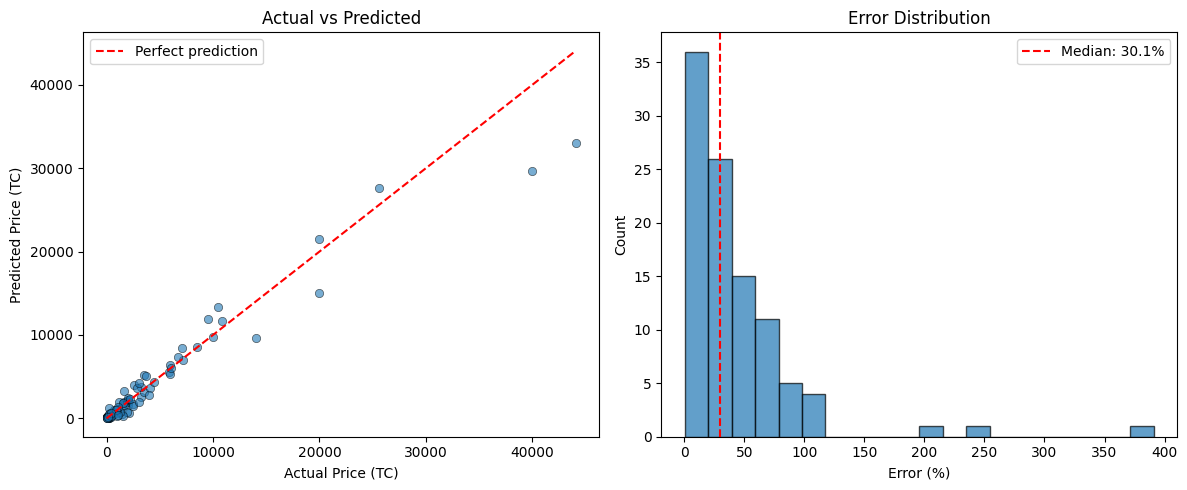


=== BEST PREDICTIONS ===
vocation  level  actual_price  predicted_price  error_percent
   Druid    421          2000             1993            0.3
  Knight    619          6005             6026            0.4
  Knight    177           301              303            0.8
Sorcerer    790          8500             8611            1.3
Sorcerer    271          1403             1373            2.1

=== WORST PREDICTIONS ===
vocation  level  actual_price  predicted_price  error_percent
  Knight    192           250             1228          391.1
  Knight    109           101              340          236.5
  Knight      8            57              173          203.1
  Knight    121            80              173          116.7
  Knight     57            57              123          115.2


In [20]:
# === MODEL VALIDATION: Predict vs Actual ===

# Random sample from test set
sample_size = 100
sample_indices = np.random.choice(len(X_test), size=sample_size, replace=False)

X_sample = X_test.iloc[sample_indices]
y_actual = y_test.iloc[sample_indices].values

# Predict and reverse log transformation
y_pred_log = log_model.predict(X_sample)
y_pred = np.expm1(y_pred_log)

# Results table
vocation_map = {0: 'Rookie', 1: 'Knight', 2: 'Paladin', 3: 'Druid', 4: 'Sorcerer', 5: 'Monk'}

results = pd.DataFrame({
    'vocation': X_sample['vocation_id'].map(vocation_map).values,
    'level': X_sample['level'].values,
    'actual_price': y_actual,
    'predicted_price': np.round(y_pred).astype(int),
    'difference': np.round(y_pred - y_actual).astype(int),
    'error_percent': np.round(np.abs(y_pred - y_actual) / y_actual * 100, 1)
})

print("=== PREDICTION vs ACTUAL (20 samples) ===\n")
print(results[['vocation', 'level', 'actual_price', 'predicted_price', 'difference', 'error_percent']].head(20).to_string(index=False))

# Metrics
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)
mape = np.mean(np.abs(y_pred - y_actual) / y_actual) * 100

print("\n=== METRICS ===")
print(f"MAE: {mae:,.0f} TC")
print(f"RMSE: {rmse:,.0f} TC")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.1f}%")

# Error by vocation
print("\n=== ERROR BY VOCATION ===")
vocation_stats = results.groupby('vocation')['error_percent'].agg(['mean', 'median', 'count']).round(1)
print(vocation_stats.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter: actual vs predicted
axes[0].scatter(y_actual, y_pred, alpha=0.6, edgecolors='black', linewidth=0.5)
max_val = max(y_actual.max(), y_pred.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Perfect prediction')
axes[0].set_xlabel('Actual Price (TC)')
axes[0].set_ylabel('Predicted Price (TC)')
axes[0].set_title('Actual vs Predicted')
axes[0].legend()

# Histogram: error distribution
axes[1].hist(results['error_percent'], bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(results['error_percent'].median(), color='red', linestyle='--', 
                label=f'Median: {results["error_percent"].median():.1f}%')
axes[1].set_xlabel('Error (%)')
axes[1].set_ylabel('Count')
axes[1].set_title('Error Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

# Best and worst predictions
print("\n=== BEST PREDICTIONS ===")
print(results.nsmallest(5, 'error_percent')[['vocation', 'level', 'actual_price', 'predicted_price', 'error_percent']].to_string(index=False))

print("\n=== WORST PREDICTIONS ===")
print(results.nlargest(5, 'error_percent')[['vocation', 'level', 'actual_price', 'predicted_price', 'error_percent']].to_string(index=False))


The final model achieves strong results with R² = 0.935 and MAE = 746 TC, showing tight clustering around the perfect prediction line across all price ranges. The error distribution has a median of 30.1%, with most predictions falling in the 20-60% range - acceptable for a market driven by subjective factors like bidding competition and buyer urgency.

Best predictions occur on "standard" high-level characters where stats align with typical market expectations - a level 619 Knight at 6005 TC predicted as 6026 TC (0.4% error), or a level 790 Sorcerer at 8500 TC predicted as 8611 TC (1.3% error). These are characters where level, skills, and price follow predictable patterns.

Worst predictions cluster around low-level Knights with suspiciously low prices (57-250 TC actual vs 123-1228 TC predicted). These 100-400% errors likely represent quick sales, character transfers between friends, or accounts with negative history (deaths, low skills for level). The model correctly identifies what such characters "should" cost based on stats, but can't see the human factors driving fire-sale prices.

Vocation-wise, Paladins remain most predictable (34.3% mean error, 27.6% median), while Knights show the highest variance (47.1% mean but only 20.7% median) - indicating a few extreme outliers pulling up the average. This suggests Knights have the widest range of "hidden value" factors not captured in our feature set.